## Decision Trees for multiclassification

### Import Data

In [1]:
#! pip install xgboost
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

### Read all the CSV files

In [2]:
%%time
df= pd.read_csv('CSV/flights_fact.csv',low_memory=False)

CPU times: total: 20.4 s
Wall time: 36.8 s


In [3]:
aircraft_dim= pd.read_csv('CSV/aircraft_dim.csv')
aircraft_dim = aircraft_dim.rename(columns={'N-Number': 'TAIL_NUMBER'})

In [4]:
airlines=pd.read_csv('CSV/airlines.csv')
airlines = airlines.rename(columns={'IATA_CODE': 'AIRLINE'})

In [5]:
date_dim=pd.read_csv('CSV/date_dim.csv')

In [6]:
arrivalAirport_dim=pd.read_csv('CSV/arrivalAirport_dim.csv')
arrivalAirport_dim = arrivalAirport_dim.rename(columns={'IATA_CODE': 'DESTINATION_AIRPORT'})

In [7]:
departureAirport_dim=pd.read_csv('CSV/departureAirport_dim.csv')
departureAirport_dim = departureAirport_dim.rename(columns={'IATA_CODE': 'ORIGIN_AIRPORT'})

In [8]:
departureTime_dim=pd.read_csv('CSV/departureTime_dim.csv')

In [9]:
arrivalTime_dim=pd.read_csv('CSV/arrivalTime_dim.csv')

* Merge the fact table with the dimension tables

In [10]:
%%time

df=pd.merge(df,aircraft_dim, on='TAIL_NUMBER', how='inner')
df=pd.merge(df,date_dim, on='dateKey', how='inner')
df=pd.merge(df,arrivalAirport_dim, on='DESTINATION_AIRPORT', how='inner')
df=pd.merge(df,departureAirport_dim, on='ORIGIN_AIRPORT', how='inner')
df=pd.merge(df,departureTime_dim,on='scheduledDeparture_key',how='inner')
df=pd.merge(df,arrivalTime_dim,on='scheduledArrival_key',how='inner')

CPU times: total: 25.3 s
Wall time: 32 s


* Create a new method called get_value that creates a new column called 'class' and assigns the values 0,1,2 to the classes early,on_time,delayed respectively if those classes appear to be 1 in the initial dataset.

In [ ]:
%%time 

def get_value(df):
    if df['early'] == 1:
        return 0
    elif df['on_time'] == 1:
        return 1
    elif df['delayed'] == 1:
        return 2

df['class'] = df.apply(lambda df: get_value(df), axis=1)


### Print merged Dataframe 

In [ ]:
df

### Remove unwanted columns

In [12]:
df=df.drop(['YEAR','FLIGHT_NUMBER','TAIL_NUMBER','TAXI_OUT','WHEELS_OFF','ELAPSED_TIME', 'AIR_TIME','WHEELS_ON',
            'TAXI_IN','CANCELLATION_REASON','ARRIVAL_DELAY','early','on_time','delayed',
              'new_delay','DIVERTED','CANCELLED','AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
                    'WEATHER_DELAY','YEAR','LATE_AIRCRAFT_DELAY','num_engines','num_passengers','Year Mfr','TypeAcft',
           'type','AircraftMFRModelCode','COUNTRY_x','COUNTRY_y'], axis=1)


In [ ]:
df.isna().sum()

In [13]:
df.dropna(subset=['LATITUDE_x','LATITUDE_y','LONGITUDE_x','LONGITUDE_y'], inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
df.info()

### Perform Correlation Statistic Test

<AxesSubplot: >

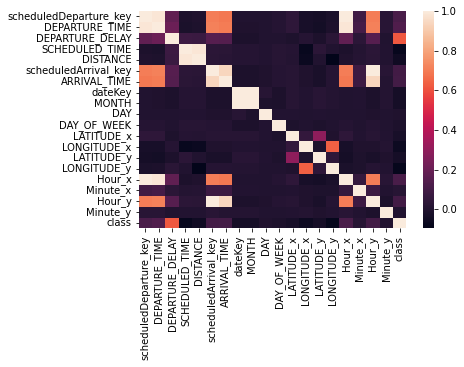

In [14]:
sns.heatmap(df.corr())

In [15]:
#columns=['FLIGHT_NUMBER','TAIL_NUMBER','scheduledDeparture_key','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF',
               #'AIR_TIME','WHEELS_ON','TAXI_IN','scheduledArrival_key','ARRIVAL_DELAY','early','on_time','delayed',
              #'new_delay','class'])
# Select the target variable
y = df['class']

# Select the feature columns
X = df.drop(columns=['class'])

# Compute the correlation matrix
corr = X.corrwith(y)

# Sort the correlations in descending order
corr_sorted = corr.sort_values(ascending=False)

# Print the sorted correlations
corr_sorted



DEPARTURE_DELAY           0.615048
DEPARTURE_TIME            0.133851
scheduledDeparture_key    0.114499
Hour_x                    0.114257
ARRIVAL_TIME              0.097204
Hour_y                    0.091624
scheduledArrival_key      0.091609
Minute_x                  0.014690
Minute_y                 -0.000238
DAY                      -0.005247
DAY_OF_WEEK              -0.014753
LATITUDE_x               -0.027424
MONTH                    -0.034027
dateKey                  -0.034159
LATITUDE_y               -0.036029
DISTANCE                 -0.053450
LONGITUDE_x              -0.060567
SCHEDULED_TIME           -0.078487
LONGITUDE_y              -0.084342
dtype: float64

In [ ]:
df

* Use the OneHotEncoder class from the sklearn.preprocessing module to perform one-hot encoding on the categorical column.

In [ ]:
airlines = df['AIRLINE'].value_counts()
top_30or=df['ORIGIN_AIRPORT'].value_counts().head(30).index.to_list()
top_30ar=df['DESTINATION_AIRPORT'].value_counts().head(30).index.to_list()

In [ ]:
df['mfr_name'].value_counts()

In [18]:
#ex_df=df[df['ORIGIN_AIRPORT'].isin(top_30or) & df['DESTINATION_AIRPORT'].isin(top_30ar)]
ex_df=df

In [19]:
%%time
# Create dummy variables for the 'AIRLINE' and 'ORIGIN_AIRPORT','DESTINATION_AIRPORT' columns
dummies = pd.get_dummies(ex_df['AIRLINE'])
#dummies1 = pd.get_dummies(ex_df['ORIGIN_AIRPORT'])
#dummies2 = pd.get_dummies(ex_df['DESTINATION_AIRPORT'])


dummies

CPU times: total: 578 ms
Wall time: 633 ms


,AA,AS,B6,DL,EV,F9,HA,MQ,NK,OO,UA,US,VX,WN
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3919448,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919449,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919450,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3919451,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [20]:
dummies3 = pd.get_dummies(ex_df['mfr_name'])

In [21]:
# Concatenate the dummy variables to the original dataframe
#df = pd.concat([df, dummies], axis=1)
ex_df=pd.concat([ex_df, dummies], axis=1)
#ex_df=pd.concat([ex_df, dummies1], axis=1)
#ex_df=pd.concat([ex_df, dummies2], axis=1)
ex_df
# Drop the original 'AIRLINE' and 'ORIGIN_AIRPORT','DESTINATION_AIRPORT' columns
ex_df = ex_df.drop(['AIRLINE', 'ORIGIN_AIRPORT','DESTINATION_AIRPORT'], axis=1)

In [22]:
ex_df=pd.concat([ex_df, dummies3], axis=1)
ex_df = ex_df.drop(['mfr_name'], axis=1)

In [23]:
ex_df.columns

Index(['scheduledDeparture_key', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'DISTANCE', 'scheduledArrival_key', 'ARRIVAL_TIME',
       'dateKey', 'model_name', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'fullDate',
       'month_name', 'day_name', 'AIRPORT_x', 'CITY_x', 'STATE_x',
       'LATITUDE_x', 'LONGITUDE_x', 'AIRPORT_y', 'CITY_y', 'STATE_y',
       'LATITUDE_y', 'LONGITUDE_y', 'Hour_x', 'Minute_x', 'Hour_y', 'Minute_y',
       'class', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO',
       'UA', 'US', 'VX', 'WN', 'AIRBUS', 'AVIAT AIRCRAFT INC', 'BARKER JACK L',
       'BEECH', 'BELL', 'BENHAM JOHN', 'BOEING', 'BOMBARDIER INC', 'CANADAIR',
       'CESSNA', 'CIRRUS DESIGN CORP', 'DASSAULT', 'DIAMOND AIRCRAFT IND INC',
       'DOUGLAS', 'EMBRAER', 'EMBRAER S A', 'EXTRA FLUGZEUGBAU GMBH',
       'GROSS ROBERT', 'GULFSTREAM AEROSPACE', 'GULFSTREAM AEROSPACE CORP',
       'KILDALL GARY', 'LAMBERT RICHARD', 'LEARJET INC', 'MARZ BARRY',
       'MCDONNELL DOUGLAS', 'M

In [24]:
#columns=['FLIGHT_NUMBER','TAIL_NUMBER','scheduledDeparture_key','DEPARTURE_DELAY','TAXI_OUT','WHEELS_OFF',
               #'AIR_TIME','WHEELS_ON','TAXI_IN','scheduledArrival_key','ARRIVAL_DELAY','early','on_time','delayed',
              #'new_delay','class'])
# Select the target variable
y = ex_df['class']

# Select the feature columns
X = ex_df.drop(columns=['class'])

# Compute the correlation matrix
corr = X.corrwith(y)

# Sort the correlations in descending order
corr_sorted = corr.sort_values(ascending=False,key=abs)

# Print the sorted correlations
corr_sorted.head(20)


DEPARTURE_DELAY                  0.615048
DEPARTURE_TIME                   0.133851
scheduledDeparture_key           0.114499
Hour_x                           0.114257
ARRIVAL_TIME                     0.097204
Hour_y                           0.091624
scheduledArrival_key             0.091609
LONGITUDE_y                     -0.084342
DL                              -0.083963
SCHEDULED_TIME                  -0.078487
WN                               0.061951
LONGITUDE_x                     -0.060567
DISTANCE                        -0.053450
HA                               0.049249
MCDONNELL DOUGLAS AIRCRAFT CO   -0.037522
LATITUDE_y                      -0.036029
BOEING                           0.035072
UA                              -0.034942
dateKey                         -0.034159
MONTH                           -0.034027
dtype: float64

* Info and analysis of data

In [ ]:
ex_df.isnull().any().value_counts()

In [ ]:
ex_df.columns

In [25]:
ex_df=ex_df.drop(['model_name','fullDate','month_name','day_name','AIRPORT_x','CITY_x','STATE_x',
              'AIRPORT_y','CITY_y','STATE_y'],axis=1)

In [ ]:
# Select only the numerical columns
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns.drop('class')

# Store the data from the numerical columns in a NumPy array
X = ex_df[numeric_columns].values

# Create the scaler
scaler = StandardScaler()

# Fit the scaler to the data
scaler.fit(X)

# Scale the data
X_scaled = scaler.transform(X)

# Update the data in the DataFrame
ex_df[numeric_columns] = X_scaled

In [26]:
ex_df.columns

Index(['scheduledDeparture_key', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'DISTANCE', 'scheduledArrival_key', 'ARRIVAL_TIME',
       'dateKey', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'LATITUDE_x', 'LONGITUDE_x',
       'LATITUDE_y', 'LONGITUDE_y', 'Hour_x', 'Minute_x', 'Hour_y', 'Minute_y',
       'class', 'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO',
       'UA', 'US', 'VX', 'WN', 'AIRBUS', 'AVIAT AIRCRAFT INC', 'BARKER JACK L',
       'BEECH', 'BELL', 'BENHAM JOHN', 'BOEING', 'BOMBARDIER INC', 'CANADAIR',
       'CESSNA', 'CIRRUS DESIGN CORP', 'DASSAULT', 'DIAMOND AIRCRAFT IND INC',
       'DOUGLAS', 'EMBRAER', 'EMBRAER S A', 'EXTRA FLUGZEUGBAU GMBH',
       'GROSS ROBERT', 'GULFSTREAM AEROSPACE', 'GULFSTREAM AEROSPACE CORP',
       'KILDALL GARY', 'LAMBERT RICHARD', 'LEARJET INC', 'MARZ BARRY',
       'MCDONNELL DOUGLAS', 'MCDONNELL DOUGLAS AIRCRAFT CO',
       'MCDONNELL DOUGLAS CORPORATION', 'PAIR MIKE E', 'PIPER',
       'RAYTHEON AIRCRAFT COMPANY', 'RO

### Decision Trees

* Assign to x all the features that we will use for prediction and assign to y the class feature that we want to predict

In [34]:
x= ex_df.drop(['DEPARTURE_DELAY','class','ARRIVAL_TIME','DAY', 'DAY_OF_WEEK','MONTH','DEPARTURE_TIME'],axis=1)  
y= ex_df['class']

In [35]:
x.columns

Index(['scheduledDeparture_key', 'SCHEDULED_TIME', 'DISTANCE',
       'scheduledArrival_key', 'dateKey', 'LATITUDE_x', 'LONGITUDE_x',
       'LATITUDE_y', 'LONGITUDE_y', 'Hour_x', 'Minute_x', 'Hour_y', 'Minute_y',
       'AA', 'AS', 'B6', 'DL', 'EV', 'F9', 'HA', 'MQ', 'NK', 'OO', 'UA', 'US',
       'VX', 'WN', 'AIRBUS', 'AVIAT AIRCRAFT INC', 'BARKER JACK L', 'BEECH',
       'BELL', 'BENHAM JOHN', 'BOEING', 'BOMBARDIER INC', 'CANADAIR', 'CESSNA',
       'CIRRUS DESIGN CORP', 'DASSAULT', 'DIAMOND AIRCRAFT IND INC', 'DOUGLAS',
       'EMBRAER', 'EMBRAER S A', 'EXTRA FLUGZEUGBAU GMBH', 'GROSS ROBERT',
       'GULFSTREAM AEROSPACE', 'GULFSTREAM AEROSPACE CORP', 'KILDALL GARY',
       'LAMBERT RICHARD', 'LEARJET INC', 'MARZ BARRY', 'MCDONNELL DOUGLAS',
       'MCDONNELL DOUGLAS AIRCRAFT CO', 'MCDONNELL DOUGLAS CORPORATION',
       'PAIR MIKE E', 'PIPER', 'RAYTHEON AIRCRAFT COMPANY',
       'ROBINSON HELICOPTER CO', 'SIKORSKY', 'SOCATA'],
      dtype='object')

* Split to trainning and testing set with a 80:20 ratio

In [36]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2,random_state=0)  

* Create a DecisionTreeClassifier based on the entropy

In [37]:
%%time
#Entropy
classifier= DecisionTreeClassifier(criterion='entropy', random_state=0)  
model=classifier.fit(x_train, y_train)  

CPU times: total: 2min 4s
Wall time: 2min 8s


* Predicting the test set result based on the Entropy

In [38]:
#Predicting the test set result (Entropy)
y_pred= classifier.predict(x_test)

In [39]:
print(classifier.tree_.max_depth)

65


 Create a DecisionTreeClassifier based on the gini index

In [ ]:
%%time
#Gini
classifier1= DecisionTreeClassifier(criterion='gini', random_state=0)  
model1=classifier1.fit(x_train, y_train) 

* Predicting the test set result based on the gini index

In [ ]:
#Predicting the test set result (Gini)
y_pred1= classifier1.predict(x_test)

### Print the classification report and interpret the results

In [40]:
# Print the classification report (Entropy)
report = classification_report(y_test, y_pred)
print(report)

# Print the F1 score
f1 = f1_score(y_test, y_pred, average="micro")
print("F1 score:", f1)

              precision    recall  f1-score   support

           0       0.49      0.56      0.52    275349
           1       0.58      0.56      0.57    396086
           2       0.25      0.20      0.22    110819

    accuracy                           0.51    782254
   macro avg       0.44      0.44      0.44    782254
weighted avg       0.50      0.51      0.50    782254

F1 score: 0.506197475500285


In [ ]:
# Print the classification report(Gini)
report = classification_report(y_test, y_pred1)
print(report)

# Print the F1 score
f1 = f1_score(y_test, y_pred1, average="micro")
print("F1 score:", f1)

### XGBOOST

In [ ]:
# Remove duplicate columns
ex_df = ex_df.loc[:, ~ex_df.columns.duplicated()]

In [ ]:
x= ex_df.drop(['class','ARRIVAL_TIME','DEPARTURE_TIME','MONTH','Hour_x','Hour_y','DAY','DAY_OF_WEEK'],axis=1)  
y= ex_df['class']

In [ ]:
x.columns

In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.25,random_state=0)  

In [ ]:
%%time
# Create the classifier
clf = XGBClassifier(max_depth=25,n_estimators=100)

# Fit the classifier to the training data
clf.fit(x_train, y_train)

# Make predictions on the test data
predictions = clf.predict(x_test)


In [ ]:
# Print the classification report(Gini)
report = classification_report(y_test, predictions)
print(report)

# Print the F1 score
f1 = f1_score(y_test, predictions, average="micro")
print("F1 score:", f1)

In [ ]:
# Calculate the confusion matrix for the test set
confusion_matrix = confusion_matrix(y_test, predictions)

# Print the confusion matrix
print(confusion_matrix)

In [ ]:
# Plot the feature importance scores, excluding the first two columns
xgb.plot_importance(clf,importance_type='weight', max_num_features=11)

### Evaluate the model 

In [ ]:
# Evaluate the model on the test data
test_score = clf.score(x_test, y_test)

# Evaluate the model on the training data
train_score = clf.score(x_train, y_train)

# Print the scores
print(f"Test score: {test_score:.3f}")
print(f"Train score: {train_score:.3f}")